### We will compare different methods

In [54]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 50

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [55]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch * 2]['source computer'].values))) 

In [56]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=time_epoch,
                                                    doScale=True, scaler='log', hosts=hosts)

In [57]:
print('Total number of hosts:', len(hosts))
print('Total datapoints:', len(groupped_data))

Total number of hosts: 1894
Total datapoints: 94700


# First method used will be a simple kmeans on the whole dataset 

Lets denote N the number of hosts, M the number of epochs. This will give us an NxM dataset with 2 points vector

We simply cluster this points together 

In [58]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

all_raw_data = groupped_data.values[:,:2]

kmeans_whole_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(all_raw_data)

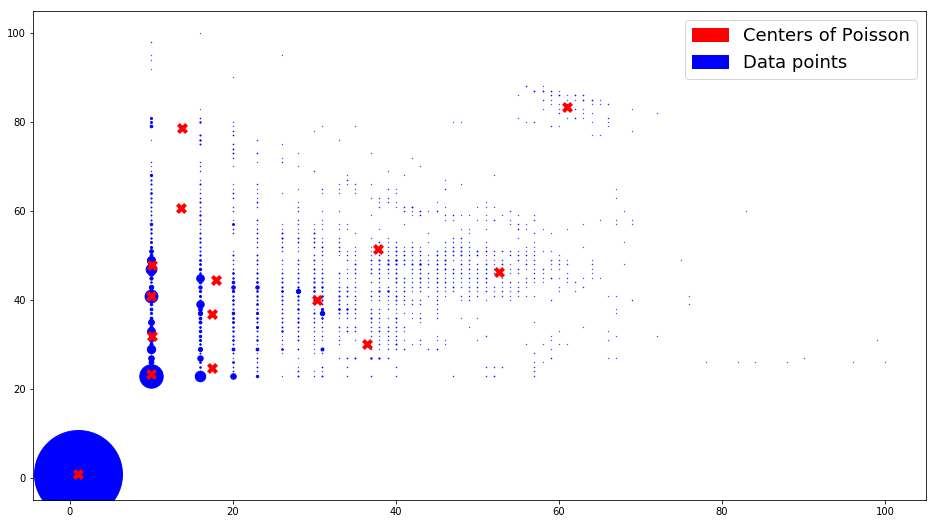

In [59]:
from plots import plot_points

# Hack in order to display the plot
kmeans_whole_data.lambdas = kmeans_whole_data.cluster_centers_

num_clusters = len(kmeans_whole_data.cluster_centers_)
kmeans_whole_data.gammas = [1/num_clusters] * num_clusters

plot_points(all_raw_data, kmeans_whole_data)

### Next we will use an average on each host

That will generate N vectors of 2 points for the 2 features 

In [60]:
groupped_data.groupby('source computer').mean().head()

,number of flows,mean(byte count),epoch
source computer,,,
C10,1.36,1.88,25.5
C100,6.88,11.56,25.5
C1000,2.98,6.86,25.5
C1001,7.90,12.04,25.5
C1002,4.24,8.92,25.5


In [61]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

host_raw_data = groupped_data.groupby('source computer').mean().values[:,:2]

kmeans_host_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(host_raw_data)

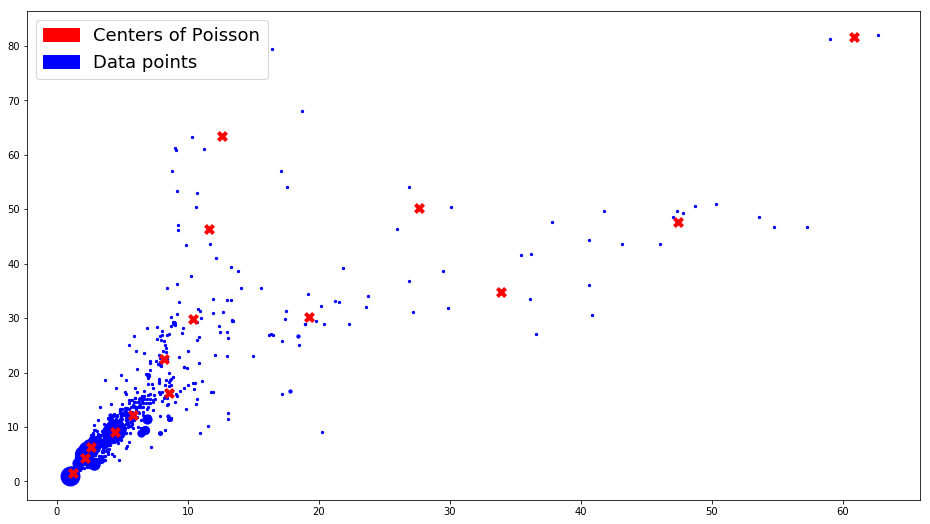

In [62]:
kmeans_host_data.lambdas = kmeans_host_data.cluster_centers_

num_clusters = len(kmeans_host_data.cluster_centers_)
kmeans_host_data.gammas = [1/num_clusters] * num_clusters

plot_points(host_raw_data, kmeans_host_data)

### Next we will use an average on each epoch
That will generate M vectors of 2 points for the 2 features

In [63]:
groupped_data.groupby('epoch').mean().head()

,number of flows,mean(byte count)
epoch,,
1,3.678458,7.653643
2,5.318374,10.655227
3,3.844773,7.916579
4,3.756600,7.863780
5,5.292503,11.153115


In [64]:
from sklearn.cluster import KMeans
import numpy as np

number_of_clusters = 15

epoch_raw_data = groupped_data.groupby('epoch').mean().values[:,:2]

kmeans_epoch_data = KMeans(n_clusters=number_of_clusters, random_state=0).fit(epoch_raw_data)

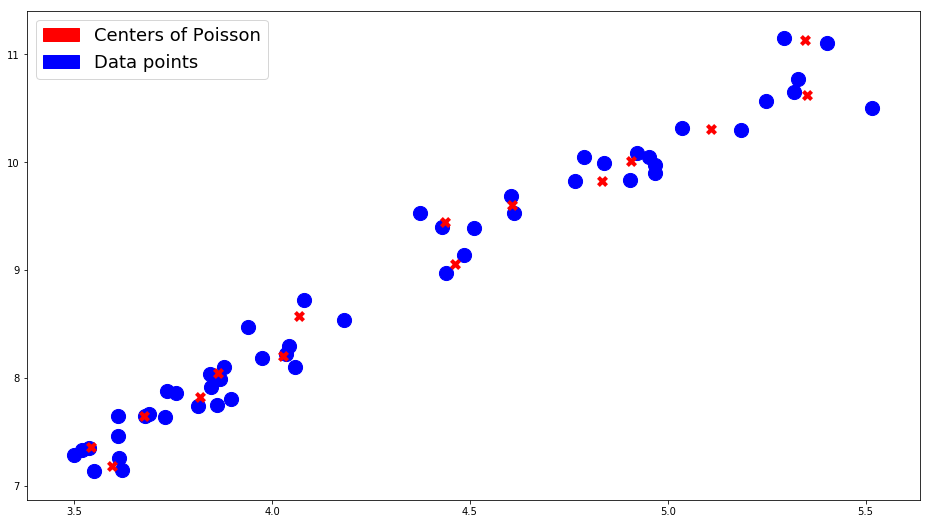

In [65]:
kmeans_epoch_data.lambdas = kmeans_epoch_data.cluster_centers_

num_clusters = len(kmeans_epoch_data.cluster_centers_)
kmeans_epoch_data.gammas = [1/num_clusters] * num_clusters

plot_points(epoch_raw_data, kmeans_epoch_data)

### Now we will test how well they can score new datapoints

In [66]:
# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[(df_all['time'] > epochs_per_batch * time_epoch) & (df_all['time'] <= epochs_per_batch * time_epoch * 2)]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
3001,0,C1685,N4,C2657,N6205,6,4,413
3001,0,C1685,N4,C2657,N6269,6,4,414
3001,0,C17,N225,C1883,445,6,1,52
3001,0,C1883,445,C17,N225,6,1,46
3001,0,C2657,N6205,C1685,N4,6,5,857


In [68]:
# scale the data using the same scaler

groupped_data_test, _ = group_scale_data_batch(df, parameters)
groupped_data_test['epoch'] += epochs_per_batch

In [87]:
from scipy.spatial.distance import euclidean

def calculate_error(algorithm, data):
    num_points = len(data)
    
    assert num_points > 0
    
    
    total_error = 0
    
    if isinstance(algorithm, KMeans):
        predictions = algorithm.predict(data)
        for data_i, prediction_i in zip(data, predictions):
            distance_to_closest_center = euclidean(data_i, algorithm.cluster_centers_[prediction_i])
            total_error += distance_to_closest_center
        
    return total_error/num_points

### First attempt to 

In [92]:
print('Error from whole kmeans clustering', calculate_error(kmeans_whole_data, groupped_data_test.values[:, :2]))
print('Error from whole kmeans clustering', calculate_error(kmeans_host_data, groupped_data_test.values[:, :2]))
print('Error from whole kmeans clustering', calculate_error(kmeans_epoch_data, groupped_data_test.values[:, :2]))

Error from whole kmeans clustering 0.51601249068
Error from whole kmeans clustering 1.51246380846
Error from whole kmeans clustering 11.3930243069


In [93]:
kmeans_whole_data.score(groupped_data_test.values[:, :2])

-251406.83640947731